The following cell handles the importing and defintions, skip to the next one to get into the nitty gritty

In [59]:
# This block will simply check for any missing python modules and will quietly install them within the Jupyter container.
# No packages will be installed within your actual python directory, so if you have any packages setup in a given way,
# they will not be overwritten
import sys, subprocess,importlib.util
required = {'numpy','matplotlib','scipy'}
installed = {pkg for pkg in required if importlib.util.find_spec(pkg) is not None}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])


import math
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import binom

def w_k(m,k):
    sum = 0
    for j in range(math.floor((k+1)/2),np.min([m,k])+1):
        sum = sum + np.power(j,m+1)*binom(m,j)*binom(2*j,j)*binom(j,k-j)/math.factorial(m)
    return np.power(-1,m+k)*sum

def poisson(t,a,k):
    return np.power(a*t,k)*np.exp(-a*t)/math.factorial(k)

def lap_trans_poisson(s,a,k):
    return np.power(a,k)/np.power(s+a,k+1)

def lap_trans_exp(s,a):
    return 1/(s-a)
def gauss(x,sigma,mu):
    return np.exp(-np.power((x-mu)/sigma,2)/2)/(sigma*np.sqrt(2*np.pi))

def lap_trans_gauss(s,sigma,mu):
    return np.exp(np.power(s*sigma,2)/2 - s*mu)

One is first introduced to Laplace Transforms in introductory differential equations class. The method transforms a differential equation into an algebraic one, making it easier to solve. Than by tabulated inverses, they obtain the solution in the original space. The transform itself is defined by the integral $$F(s) = \int_{0}^{\infty}f(t)e^{-st}dt$$ If you have been reading closely, the term tabulated inverses should have stood out, because unlike Fourier transforms, where you just handle a factor of 2$\pi$ and flip the parity of exponent, the inverse Laplace transform is given by the Bromwich integral $$f(t) = \frac{1}{2\pi i}\int_{\gamma - i\infty}^{\gamma + i\infty}F(s)e^{st}$$ which is a complex contour integral. The tabluated inverses are calculated by various methods such as Cauchy method or the Residue theorem. We won't dive into them, you can find a detailed explanation in Mathematical Methods for Physicists by Arfken et al. But as the seasoned veterans out there can confirm, it's no simple feat; especially when the function isn't so well behaved. Another issue arises from doing contour integrations numerically on the real axis, let alone translating it to the complex plane with infinite bounds. 

For most applications, one must sample the laplace space function $F(s)$ on the real line. Let us define a new complex variable $z = st$ and replace it in the Bromwich integral 
$$f(t) = \frac{1}{2\pi i t}\int_{\gamma - i\infty}^{\gamma + i\infty}F(\frac{z}{t})e^{z}dz$$

Approximating the exponential by a rational function $$e^{z} \approx \sum_{k=0}^{n}\frac{\omega_{k}}{\alpha_{k}-z}$$ where $w_{k}$ and $\alpha_{k}$ are both complex and are called weights and nodes respectively. Replacing the approximation and applying the Cauchy integral formula, we get 

$$f(t) \approx \frac{1}{t}\sum_{k=0}^{n}\omega_{k}F\left(\frac{\alpha_{k}}{t}\right)$$

The nodes and weights are complex numbers but do not depend on F of the function argument t, but typically depend upon n. The Gaver-Stehfest method considers the case where f(t), the weights, and the nodes are real. The algorithm is based on a probabilistic derivation and grants the following form
$$f(t) \approx \frac{\ln(2)}{t} \sum_{k=1}^{2M} \omega_{k} F(\frac{k\ln(2)}{t})$$ 

with the weights as
$$\omega_{k} = (-1)^{M+k}\sum_{j=floor((k+1)/2)}^{min(k,M)} \frac{j^{M+1}}{M!} {M \choose j} {2j \choose j}{j \choose k-j}$$

The form works best for functions of the form $e^{-\alpha t}$, making it particularly useful for transforms of Poisson Distributions
The box below is for parameters, you can add definitions for functions and their Laplace transforms in the above cell to test out 

In [60]:
#number of terms in the sum
m = 7

In this example, we will illustrate the effectiveness of the Gaver-Stehfest over 3 value of $\alpha=$ 1 ,2 and 10

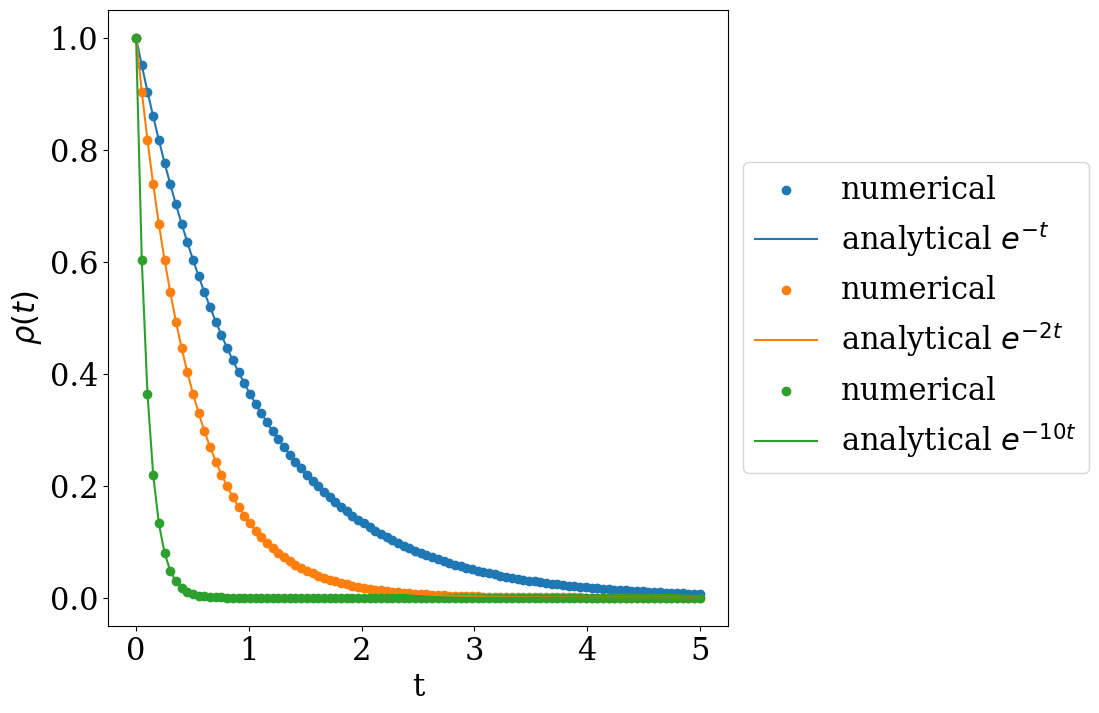

In [61]:
#exponential parameter
a = -1
a1 = -2
a2 = -10
#real axis
t = np.linspace(1e-5,5,100)
#arrays for calculating the sum
f_calc = np.zeros(np.size(t))
f_calc1 = np.zeros(np.size(t))
f_calc2 = np.zeros(np.size(t))
#calculate the weights
wk = np.empty(2*m)
for i in range(2*m):
    wk[i] = w_k(m,i+1)
#calculate the transform
for j in range(2*m):
    f_calc = f_calc + np.log(2)*wk[j]*lap_trans_exp((j+1)*np.log(2)/t,a)/t
    f_calc1 = f_calc1 + np.log(2)*wk[j]*lap_trans_exp((j+1)*np.log(2)/t,a1)/t
    f_calc2 = f_calc2 + np.log(2)*wk[j]*lap_trans_exp((j+1)*np.log(2)/t,a2)/t
   
#graph
plt.figure(figsize=(8,8))
plt.rc('font', family='serif')

plt.rcParams['font.size']=22


plt.scatter(t,f_calc,label = 'numerical')
plt.plot(t,np.exp(a*t),label = r'analytical $e^{-t}$')
plt.scatter(t,f_calc1,label = 'numerical')
plt.plot(t,np.exp(a1*t),label = r'analytical $e^{-2t}$')
plt.scatter(t,f_calc2,label = 'numerical')
plt.plot(t,np.exp(a2*t),label = r'analytical $e^{-10t}$')
plt.ylabel(r'$\rho(t)$')
plt.xlabel('t')
plt.legend(loc = 'center left',bbox_to_anchor=(1,0.5))

plt.show()

As you can see, the method works flawlessly for decaying exponentials. How about Poisson distributions? They have the form $$f(t) = \frac{(at)^{k}e^{-at}}{k!}$$ and the Laplace transform is $$F(s) = \frac{a^{k}}{(s+a)^{k+1}}$$
Let's take a poisson distribution of number of occurences 2, 5 and 7, just to get a sampling

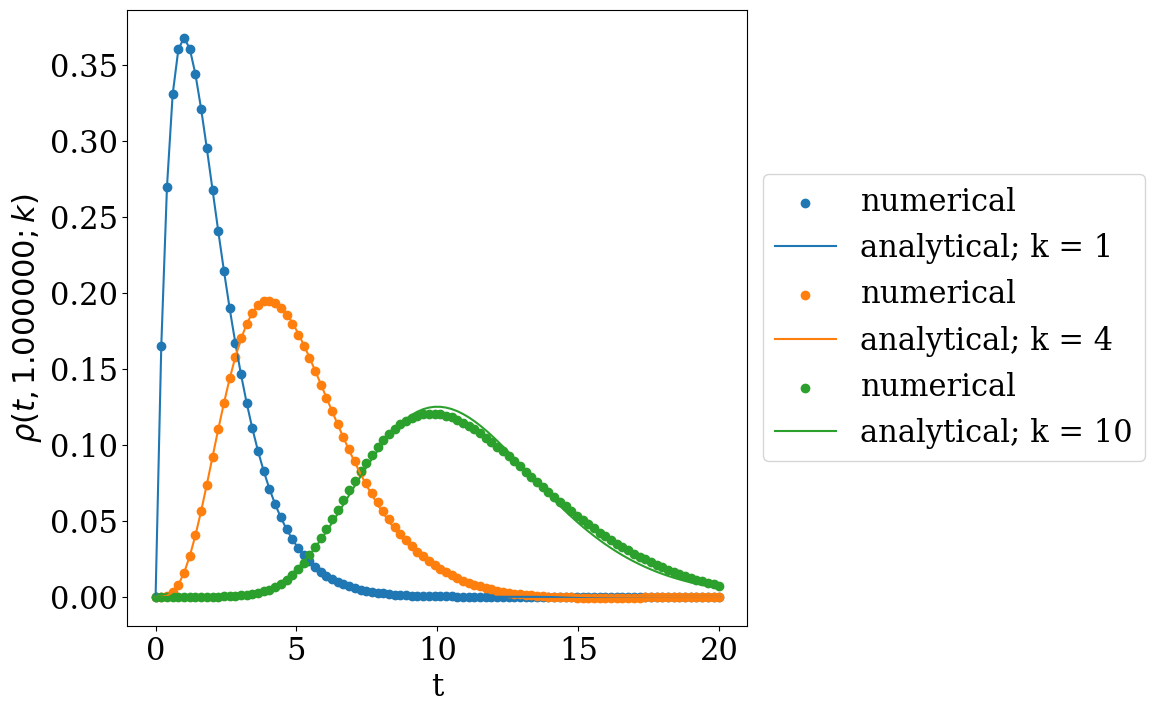

In [62]:
t = np.linspace(1e-5,20,100)
#Poisson parameter; 
a = 1
k1 = 1
k2 = 4
k3 = 10
#arrays for calculating the sum
f_calc = np.zeros(np.size(t))
f_calc1 = np.zeros(np.size(t))
f_calc2 = np.zeros(np.size(t)) 

for j in range(2*m):
    f_calc = f_calc + np.log(2)*wk[j]*lap_trans_poisson((j+1)*np.log(2)/t,a,k1)/t
    f_calc1 = f_calc1 + np.log(2)*wk[j]*lap_trans_poisson((j+1)*np.log(2)/t,a,k2)/t
    f_calc2 = f_calc2 + np.log(2)*wk[j]*lap_trans_poisson((j+1)*np.log(2)/t,a,k3)/t

#graph
plt.figure(figsize=(8,8))

plt.rc('font', family='serif')
plt.rcParams['font.size']=22
plt.scatter(t,f_calc,label = 'numerical')
plt.plot(t,poisson(t,a,k1),label = 'analytical; k = '+str(k1))
plt.scatter(t,f_calc1,label = 'numerical')
plt.plot(t,poisson(t,a,k2),label = 'analytical; k = '+str(k2))
plt.scatter(t,f_calc2,label = 'numerical')
plt.plot(t,poisson(t,a,k3),label = 'analytical; k = '+str(k3))
plt.legend(loc = 'center left',bbox_to_anchor=(1,0.5))
plt.xlabel('t')
plt.ylabel(r'$\rho(t,%f;k)$'%(a))

plt.show()

Now let's see what happens with Gaussian distributions, which have the form $$f(t) = \frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{1}{2}(\frac{t-\mu}{\sigma})^{2}}$$ with Laplace transform $$ F(s) = e^{\frac{(s\sigma)^{2}}{2} -s\mu} $$

Since the form of the transform is an exponential, we don't expect it to work perfectly. And since Gaussians can be centered at zero, the method itself would diverge since you are dividing by zero

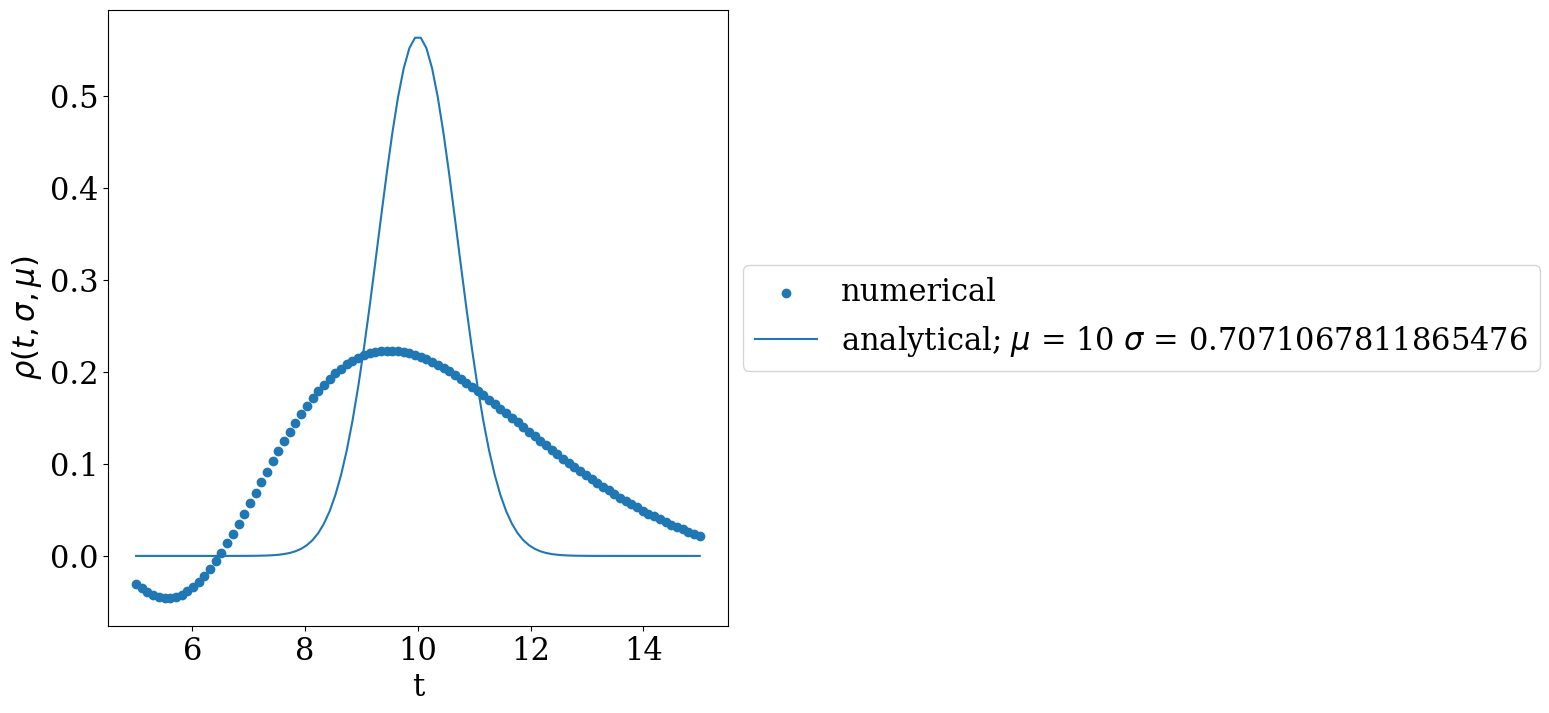

In [63]:
#gaussian parameters
sigma = np.sqrt(0.5)
mu = 10

t = np.linspace(5,15,100)


#arrays for calculating the sum
f_calc = np.zeros(np.size(t))
for j in range(2*m):
    f_calc = f_calc + np.log(2)*wk[j]*lap_trans_gauss((j+1)*np.log(2)/t,sigma,mu)/t
    

#graph
plt.figure(figsize=(8,8))

plt.rc('font', family='serif')
plt.rcParams['font.size']=22
plt.scatter(t,f_calc,label = 'numerical')
plt.plot(t,gauss(t,sigma,mu),label = r'analytical; $\mu $ = '+str(mu)+r' $\sigma$ = '+str(sigma))

plt.xlabel('t')
plt.ylabel(r'$\rho(t,\sigma,\mu)$')

plt.legend(loc = 'center left',bbox_to_anchor=(1,0.5))

plt.show()

